# Introduction

The purpose of this notebook is to summarize the basic procedure for calculating the probability that a star is a member of an isochrone (this is denoted $u_{color}$ in the `ugali` notation). For simplicity's sake, we analyze only one star and use a simple linear model for the isochrone. 

Apart from these simplification, we attempt to stay true to the analysis procedure. The isochrone model is built as a collection of points in color-magnitude space. We framework for the numerical calculation, though for this simplified case it is overly complex.

NB: I am casual about referring to the "position" of the star or isochrone. This should always be interpreted as the "position in color-magnitude space".

In [1]:
%matplotlib inline
import numpy as np
import pylab as plt
import scipy.ndimage as nd
from scipy import stats
import pylab as plt
from scipy.interpolate import RectBivariateSpline

In [2]:
# The position of the target star
x,y = np.array((2.17,3.03))
# and its associated uncertainty
xerr,yerr = 0.5,0.5

# The discrete isochrone model (we assume no uncertainty)
xmin = ymin = 0
xmax = ymax = 10
npts = 100
iso_x, iso_y = np.linspace(xmin,xmax,npts,endpoint=False),np.linspace(ymin,ymax,npts,endpoint=False)

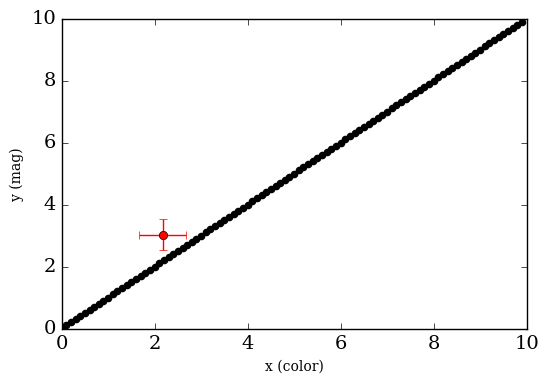

In [3]:
# Plot the isochrone and the star.
plt.figure()
plt.errorbar(x,y,xerr=xerr,yerr=yerr,color='r',fmt='o')
plt.scatter(iso_x,iso_y,c='k')
plt.xlim(xmin,xmax); plt.ylim(ymin,ymax)
plt.xlabel('x (color)'); plt.ylabel('y (mag)')

# Membership Probability

The membership probability, $u$, is proportional to the product of the stellar pdf and the isochrone pdf integrated over color-magnitude space. If both the position of the star and the isochrone are known exactly, then they are both $\delta$-functions and the probability will only be non-zero when they exactly overlap. In reality, there is uncertainty on the measured position of the star. (There may also be a random intrinsic dispersion that broadens the pdf of the isochrone, but that is not considered here.)

We can incorporate the uncertainty on the measured position of the star in two ways: 
* We can convolve the measured position of the star with its uncertainty. This takes the $\delta$-function of the stars position and broadens it into a 2D gaussian. We can then integrate the product of the star's pdf times the isochrone pdf. Since the isochrone is a $\delta$-functions, this product will only be non-zero when the star's pdf overlaps one of the isochrone's points.
* We can convolve the isochrone with the measurement uncertainty of the star. This effectively broaden the pdf of the isochrone from an infintessimal width line to a Gaussian. We can then evaluate the pdf of the broadened isochrone at the measured position of the star (a $\delta$-function in position).

These two approaches should give identical results (at least subject to our model assumptions). We start out with a simple solution to the first approach, and subsequently add the numerical complexity necessary for improved performance.

## Simple Solution

The simple solution is to convolve the $\delta$-function position of the star with its (Gaussian) uncertainty. This creates a 2D Gaussian pdf for the star, which we multiply by the isochrone pdf. The isochrone pdf is composed of a set of points ($\delta$-functions), so integral of the star pdf times the isochrone pdf will evaluate to zero everywhere except at the isochrone points. This means that we can evaluate the integral by just summing the value of the star pdf at the location of each isochrone point.

In [4]:
# Simple solution

# Change variables to scale the distance in terms of the uncertainty
dx = np.abs(iso_x - x)/xerr
dy = np.abs(iso_y - y)/yerr

# The change of variables allows us to use a standard normal pdf
pdf_x = stats.norm.pdf(dx)
pdf_y = stats.norm.pdf(dy)

# The pdf of the star is the product of the 1D pdfs
pdf_star = pdf_x * pdf_y
# The isochrone pdf needs to be normalized
pdf_iso = 1./len(iso_x)

# The integral over all space needs to have the change of variables
simple_prob = np.sum(pdf_star * pdf_iso) * (1/xerr) * (1/yerr)
print "Membership probability: ", simple_prob

Membership probability:  0.0269290395921


# Binned Solution

The simple solution discussed in the previous section suffers from one major drawback. It scales with the number of stars *and* the number of isochrone ponts. We can reduce this second dimensionality if we instead bin the isochrone points and integrate over the resulting 2D histogram.

In [5]:
# Wrap a function for creating a 2D-histogram
def histo(x,y,delta,**kwargs):
    """
    Histogram the isochrone in mag-mag space.
    """
    bins_x = np.arange(x.min()-0.5*delta,x.max()+0.5*delta,delta)
    bins_y = np.arange(y.min()-0.5*delta,y.max()+0.5*delta,delta)
    return bins_x,bins_y,np.histogram2d(x,y,bins=[bins_x, bins_y],**kwargs)[0]

In [6]:
def triinterp2d(x,y,z,**kwargs):
    """                                                                              
    Create a linear triangular interpolation using the mlab implementation.          
                                                                                     
    See `matplotlib.tri.LinearTriInterpolator`                                       
                                                                                     
    Returns a numpy masked array.                                                    
    """
    import warnings
    from matplotlib import tri as mtri
    warnings.simplefilter(action="ignore", category=FutureWarning)
    triang = mtri.Triangulation(x.flat, y.flat)
    return mtri.LinearTriInterpolator(triang, z.flat)


Isochrone normalization:  1.0


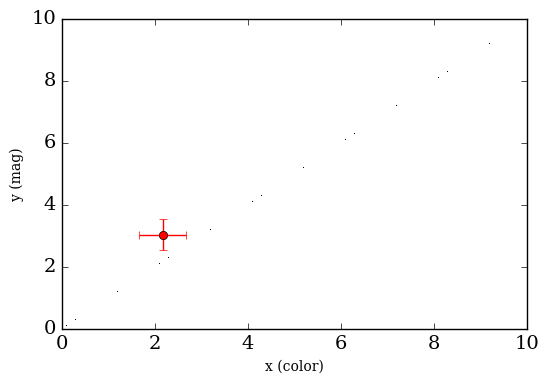

In [7]:
# The real analysis requires speed, so we bin everything

# Build a 2D-histogram populated with the isochrone points
delta = 0.01
bins_x,bins_y,nhist = histo(iso_x,iso_y,delta,normed=True)
bx, by = bins_x[1:],bins_y[1:]

# x and y coordinates of each bin (actually the left bin edge)
yy,xx = np.meshgrid(bx,by)

# Array index of the star
ix,iy = np.argmin(np.abs(bx-x)),np.argmin(np.abs(by-y))

# Plot the isochrone 2D-pdf and the location of the star. 
# Note that the isochrone is discrete points, so it sparsely fills the histogram (hard to see)
plt.pcolormesh(xx,yy,nhist,cmap='binary'); plt.xlim(xmin,xmax); plt.ylim(ymin,ymax)
plt.errorbar(x,y,xerr=xerr,yerr=yerr,color='r',fmt='o')
plt.xlabel('x (color)'); plt.ylabel('y (mag)')

# Check that the histogram is normalized over 2D space
print "Isochrone normalization: ", nhist.sum() * delta * delta

## Star Convolution

Here we convolve the star pdf with its uncertainty and evaluate at each isochrone point. This is the same concept as the first example, but is done in a binned manner that more easily incorporates complicated isochrone models (i.e., with intrinsic dispersion).

Normalization of x-pdf:  0.999992878209
Normalization of y-pdf:  0.99999999932
Normalization of 2D pdf:  0.999992877529
Membership probability:  0.0269290395921


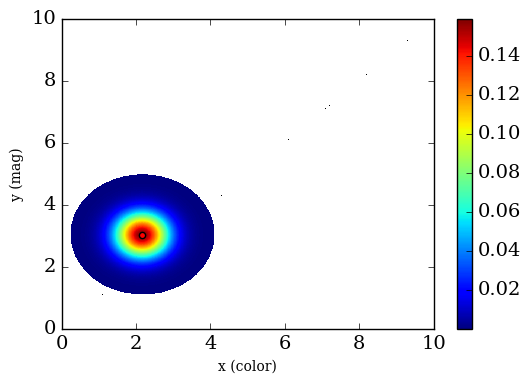

In [8]:
# Binned convolution

# Now we convolve the location of the star
dx = (xx - x)/xerr
dy = (yy - y)/yerr

# By dividing by xerr and yerr we can use a unit normal pdf
pdf_x = stats.norm.pdf(dx)
pdf_y = stats.norm.pdf(dy)
pdf_star = (pdf_x*pdf_y)

# Make sure everything is normalized
# Note that the bin sizes changed when we divided by xerr,yerr in calculating dx,dy
print "Normalization of x-pdf: ",np.sum(pdf_x[:,iy] * delta/xerr) 
print "Normalization of y-pdf: ",np.sum(pdf_y[ix,:] * delta/yerr)
print "Normalization of 2D pdf: ",np.sum(pdf_star) * (delta/xerr)*(delta/yerr)

# Plot the convolved pdf of the star and the discrete isochrone
if True:
    zz = np.ma.array(pdf_star,mask= pdf_star < 1e-4)
    plt.pcolormesh(xx,yy,nhist,cmap='binary')
    plt.pcolormesh(xx,yy,zz); plt.colorbar()
    plt.scatter(x,y,c='r')
    plt.xlim(xmin,xmax); plt.ylim(ymin,ymax)
    plt.xlabel('x (color)'); plt.ylabel('y (mag)')

# Evaluate the probability at the star
star_conv_prob = np.sum(pdf_x * pdf_y * nhist) * (delta/xerr)*(delta/yerr)
print "Membership probability: ", star_conv_prob

## Isochrone Convolution

Next we convolve the isochrone with the measurement uncertainty on the star and then evaluate the convolved isochrone pdf at the location of the star. This would be hugely beneficial if the stellar uncertainty could be described consistently for all stars. However, we are in the situation where we have varying survey depth, etc., so it seems safer to use the uncertainty on each star individually. 

Convolved isochrone normalization:  0.925051583314
Membership probability:  0.0269290687553


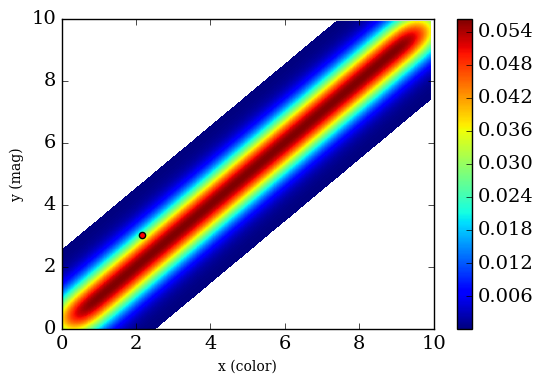

In [9]:
# First we convolve the isochrone with the measurement uncertainties of the star
pdf_iso = nd.gaussian_filter(nhist,(yerr/delta,xerr/delta), truncate=5, mode='constant')

# The Gaussian filter is messy at the boundaries and distorts the normalization
print "Convolved isochrone normalization: ", np.sum(pdf_iso) * delta * delta
# Hoever, the star is far enough from the boundaries to not be affected

# Plot the convolved isochrone and the location of the star
if True:
    zz = np.ma.array(pdf_iso,mask=pdf_iso < 1e-4)
    plt.pcolormesh(xx,yy,zz); plt.colorbar()
    plt.scatter(x,y,c='r')
    plt.xlim(xmin,xmax); plt.ylim(ymin,ymax)
    plt.xlabel('x (color)'); plt.ylabel('y (mag)')

# Index to roughly the right location in the grid
#print x, y
#print xx[ix,iy],yy[ix,iy]
#iso_conv_prob = pdf_iso[ix,iy]

# Interpolate to the exact location 
spline = RectBivariateSpline(bx,by,pdf_iso)
iso_conv_prob = spline(x,y)[0][0]

print "Membership probability: ", iso_conv_prob

# More Detail...

The above analysis is a fairly simple description of the analysis. The actual analysis adds complexity for a few reasons:
* We want to vectorize over the stars so that we can calculate all of the membership probabilities simultaneously
* Because each star has a different measurement uncertainty, it is difficult to vectorize the isochrone convolution, so we choose to do the stellar convolution.
* Instead of evaluating the pdf at each bin, we calculate the difference of the cdf at the two bin edges. This provides increased numerical accuracy in the case where the bins are large compared to the stellar pdf.

Normalization of x-pdf:  0.999992875864
Normalization of y-pdf:  0.999999999319
Normalization of 2D pdf:  0.999992875184
Membership probability:  0.0269292546543


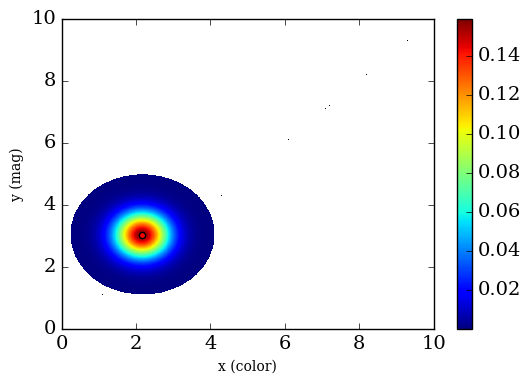

In [10]:
# Now we convolve the location of the star
dx_hi = (xx - bx[ix])/xerr
dx_lo = (xx - bx[ix+1])/xerr

dy_hi = (yy - by[iy])/yerr
dy_lo = (yy - by[iy+1])/yerr

# These are not really the pdf, but the pdf * (dx_hi - dx_lo)
pdf_x = (stats.norm.cdf(dx_hi) - stats.norm.cdf(dx_lo)) * (xerr/delta)
pdf_y = (stats.norm.cdf(dy_hi) - stats.norm.cdf(dy_lo)) * (yerr/delta)

pdf_star = pdf_x * pdf_y 

# Make sure everything is normalized
# Note that the bin sizes changed when we divided by xerr,yerr in calculating dx,dy
print "Normalization of x-pdf: ",np.sum(pdf_x[:,iy]) * delta/xerr
print "Normalization of y-pdf: ",np.sum(pdf_y[ix,:]) * delta/yerr
print "Normalization of 2D pdf: ",np.sum(pdf_star) * (delta/xerr) * (delta/yerr)

# Plot the convolved pdf of the star and the discrete isochrone
if True:
    zz = np.ma.array(pdf_star,mask= pdf_star < 1e-4)
    plt.pcolormesh(xx,yy,nhist,cmap='binary')
    plt.pcolormesh(xx,yy,zz); plt.colorbar()
    plt.scatter(x,y,c='r')
    plt.xlim(xmin,xmax); plt.ylim(ymin,ymax)
    plt.xlabel('x (color)'); plt.ylabel('y (mag)')
    
# Evaluate the probability at the star
star_cdf_prob = np.sum(pdf_x * pdf_y * nhist) * (delta/xerr) * (delta/yerr)
print "Membership probability: ",star_cdf_prob

# Moment of truth...

So now we would like to compare the various techniques of estimating the membership probability. Do they match up...?

In [11]:
print "Membership probability from the simple solution:  ",simple_prob
print "Membership probability from convolving star:      ", star_conv_prob
print "Membership probability from convolving isochrone: ", iso_conv_prob
print "Membership probability from CDF convolution:      ", star_cdf_prob

Membership probability from the simple solution:   0.0269290395921
Membership probability from convolving star:       0.0269290395921
Membership probability from convolving isochrone:  0.0269290687553
Membership probability from CDF convolution:       0.0269292546543


...close enough for me.